In [51]:
import pandas as pd
import sqlite3

In [52]:
csv_path = 'data/WA_Fn-UseC_-Telco-Customer-Churn.csv'

df = pd.read_csv(csv_path)
print("Données chargées depuis le fichier CSV.")

df.info()
df.head()

Données chargées depuis le fichier CSV.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  Pa

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [53]:
db_path = 'telco_churn.db'

table_name = 'customers'

conn = sqlite3.connect(db_path)

df.to_sql(table_name, conn, if_exists='replace', index=False)

conn.close()
print(f"La base de données {db_path} a été créée avec la table {table_name}.")

La base de données telco_churn.db a été créée avec la table customers.


In [54]:
conn = sqlite3.connect(db_path)

# Taux de churn global
query_kpi = """
SELECT
    ROUND(AVG(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) * 100, 2) AS churn_rate_percentage
FROM customers;
"""
kpi_result = pd.read_sql_query(query_kpi, conn)
print("Taux de churn global (%):")
print(kpi_result)

# Vérification de l'hypothèse 1
# "Les clients avec un contrat 'Month-to-month' churnent-ils plus ?"
query_h1 = """
SELECT
    Contract,
    ROUND(AVG(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) * 100, 2) AS churn_rate_percentage
FROM customers
GROUP BY Contract;
"""
h1_result = pd.read_sql_query(query_h1, conn)
print("Vérification de l'hypothèse 1:")
print(h1_result)

conn.close()

Taux de churn global (%):
   churn_rate_percentage
0                  26.54
Vérification de l'hypothèse 1:
         Contract  churn_rate_percentage
0  Month-to-month                  42.71
1        One year                  11.27
2        Two year                   2.83


Telco perd 26.5% de ses clients (sur la période/le scope de ces données). C'est énorme. Le "problème flou" de la problématique est confirmé.
Hypothèse H1 validée. Les clients sans engagement (Month-to-month) partent presque 4 fois plus que ceux engagés 1 an, et 15 fois plus que ceux engagés 2 ans.

Recommandation : On sait déjà que le levier le plus puissant est l'engagement. Une action business pourrait être : "Comment faire basculer les clients 'Month-to-month' vers un contrat 'One year' ?" (ex: promotion, etc.).

Maintenant qu'on sait où est le problème (les clients Month-to-month), on doit comprendre pourquoi ils partent. On va tester nos autres hypothèses.

In [55]:
conn = sqlite3.connect(db_path)

# VERIFICATION DE L'HYPOTHESE 3
# "Le churn est-il plus concentré chez les nouveaux clients ?"
query_h3 = """
SELECT
    CASE
        WHEN tenure <= 12 THEN '0-12 months'
        WHEN tenure <= 24 THEN '13-24 months'
        WHEN tenure <= 48 THEN '25-48 months'
        WHEN tenure <= 60 THEN '49-60 months'
        ELSE '61+ months'
    END AS tenure_group,
    ROUND(AVG(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) * 100, 2) AS churn_rate_percentage
FROM customers
GROUP BY tenure_group;
"""
h3_result = pd.read_sql_query(query_h3, conn)
print("VÉRIFICATION DE L'HYPOTHÈSE 3:")
print(h3_result)

# VERIFICATION DE L'HYPOTHESE 4
# "Les clients sans 'TechSupport' partent-ils plus ?"
query_h4 = """
SELECT
    TechSupport,
    ROUND(AVG(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) * 100, 2) AS churn_rate_percentage
FROM customers
GROUP BY TechSupport;
"""
h4_result = pd.read_sql_query(query_h4, conn)
print("VÉRIFICATION DE L'HYPOTHÈSE 4:")
print(h4_result)


# VERIFICATION DE L'HYPOTHESE 5
# "Le type d'internet (Fibre/DSL) a-t-il un impact ?"
query_h5 = """
SELECT
    InternetService,
    ROUND(AVG(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) * 100, 2) AS churn_rate_percentage
FROM customers
GROUP BY InternetService;
"""
h5_result = pd.read_sql_query(query_h5, conn)
print("VÉRIFICATION DE L'HYPOTHÈSE 5:")
print(h5_result)

conn.close()

VÉRIFICATION DE L'HYPOTHÈSE 3:
   tenure_group  churn_rate_percentage
0   0-12 months                  47.44
1  13-24 months                  28.71
2  25-48 months                  20.39
3  49-60 months                  14.42
4    61+ months                   6.61
VÉRIFICATION DE L'HYPOTHÈSE 4:
           TechSupport  churn_rate_percentage
0                   No                  41.64
1  No internet service                   7.40
2                  Yes                  15.17
VÉRIFICATION DE L'HYPOTHÈSE 5:
  InternetService  churn_rate_percentage
0             DSL                  18.96
1     Fiber optic                  41.89
2              No                   7.40


L'hypothèse H3 est validée. Le churn n'est pas linéaire, c'est une chute libre la première année. Telco perd la moitié des clients qui sont là depuis moins d'un an. Action Business : L'effort de rétention ne doit pas être le même pour tous. Il faut un programme intensif d'onboarding et de suivi pendant les 12 premiers mois.

H4 validée. Les clients sans support technique partent presque 3 fois plus que ceux qui l'ont. Ce n'est pas juste un "nice-to-have", c'est un service de rétention majeur. Ils se sentent probablement frustrés et abandonnés face à un problème.

H5 validée, c'est l'insight le plus contre-intuitif. On pourrait penser que la Fibre, le service "premium", retient les clients. C'est l'inverse. Les clients Fibre churnent massivement (plus de 40%), bien plus que les clients DSL

On peut se poser ces questions maintenant : pourquoi le produit le plus moderne perd-il le plus de clients ? Est-ce le prix ? L'instabilité du service ? La qualité de l'installation ?
On doit croiser ces segments. Par exemple : "Quel est le churn des clients 'Fibre' QUI SONT AUSSI 'Month-to-Month' ?"

In [56]:
conn = sqlite3.connect(db_path)

query_final_extract = """
SELECT
    customerID,
    gender,
    SeniorCitizen,
    tenure,
    Contract,
    PaymentMethod,
    InternetService,
    TechSupport,
    OnlineSecurity,
    MonthlyCharges,
    TotalCharges,
    Churn
FROM customers;
"""

df_main = pd.read_sql_query(query_final_extract, conn)

conn.close()

print("Extrait final des données pour analyse approfondie :")
df_main.head()

Extrait final des données pour analyse approfondie :


,customerID,gender,SeniorCitizen,tenure,Contract,PaymentMethod,InternetService,TechSupport,OnlineSecurity,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,1,Month-to-month,Electronic check,DSL,No,No,29.85,29.85,No
1,5575-GNVDE,Male,0,34,One year,Mailed check,DSL,No,Yes,56.95,1889.5,No
2,3668-QPYBK,Male,0,2,Month-to-month,Mailed check,DSL,No,Yes,53.85,108.15,Yes
3,7795-CFOCW,Male,0,45,One year,Bank transfer (automatic),DSL,Yes,Yes,42.30,1840.75,No
4,9237-HQITU,Female,0,2,Month-to-month,Electronic check,Fiber optic,No,No,70.70,151.65,Yes


In [57]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customerID       7043 non-null   object 
 1   gender           7043 non-null   object 
 2   SeniorCitizen    7043 non-null   int64  
 3   tenure           7043 non-null   int64  
 4   Contract         7043 non-null   object 
 5   PaymentMethod    7043 non-null   object 
 6   InternetService  7043 non-null   object 
 7   TechSupport      7043 non-null   object 
 8   OnlineSecurity   7043 non-null   object 
 9   MonthlyCharges   7043 non-null   float64
 10  TotalCharges     7043 non-null   object 
 11  Churn            7043 non-null   object 
dtypes: float64(1), int64(2), object(9)
memory usage: 660.4+ KB


In [58]:
df_main['TotalCharges'] = pd.to_numeric(df_main['TotalCharges'], errors='coerce')

df_main['Churn_numeric'] = df_main['Churn'].apply(lambda x: 1 if x == 'Yes' else 0) 

df_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customerID       7043 non-null   object 
 1   gender           7043 non-null   object 
 2   SeniorCitizen    7043 non-null   int64  
 3   tenure           7043 non-null   int64  
 4   Contract         7043 non-null   object 
 5   PaymentMethod    7043 non-null   object 
 6   InternetService  7043 non-null   object 
 7   TechSupport      7043 non-null   object 
 8   OnlineSecurity   7043 non-null   object 
 9   MonthlyCharges   7043 non-null   float64
 10  TotalCharges     7032 non-null   float64
 11  Churn            7043 non-null   object 
 12  Churn_numeric    7043 non-null   int64  
dtypes: float64(2), int64(3), object(8)
memory usage: 715.4+ KB


In [59]:
print(f"Nombre de NaN dans TotalCharges : {df_main['TotalCharges'].isnull().sum()}")

Nombre de NaN dans TotalCharges : 11


In [60]:
nan_clients = df_main[df_main['TotalCharges'].isnull()]

print("\n--- Profil des clients avec NaN ---")
nan_clients


--- Profil des clients avec NaN ---


,customerID,gender,SeniorCitizen,tenure,Contract,PaymentMethod,InternetService,TechSupport,OnlineSecurity,MonthlyCharges,TotalCharges,Churn,Churn_numeric
488,4472-LVYGI,Female,0,0,Two year,Bank transfer (automatic),DSL,Yes,Yes,52.55,NaN,No,0
753,3115-CZMZD,Male,0,0,Two year,Mailed check,No,No internet service,No internet service,20.25,NaN,No,0
936,5709-LVOEQ,Female,0,0,Two year,Mailed check,DSL,No,Yes,80.85,NaN,No,0
1082,4367-NUYAO,Male,0,0,Two year,Mailed check,No,No internet service,No internet service,25.75,NaN,No,0
1340,1371-DWPAZ,Female,0,0,Two year,Credit card (automatic),DSL,Yes,Yes,56.05,NaN,No,0
3331,7644-OMVMY,Male,0,0,Two year,Mailed check,No,No internet service,No internet service,19.85,NaN,No,0
3826,3213-VVOLG,Male,0,0,Two year,Mailed check,No,No internet service,No internet service,25.35,NaN,No,0
4380,2520-SGTTA,Female,0,0,Two year,Mailed check,No,No internet service,No internet service,20.00,NaN,No,0
5218,2923-ARZLG,Male,0,0,One year,Mailed check,No,No internet service,No internet service,19.70,NaN,No,0
6670,4075-WKNIU,Female,0,0,Two year,Mailed check,DSL,Yes,No,73.35,NaN,No,0


In [61]:
df_main['TotalCharges'] = df_main['TotalCharges'].fillna(0)

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

On a vu que la Fibre avait un churn énorme (41.89%). Mais pourquoi ? Est-ce juste la fibre, ou est-ce que les clients Fibre paient plus cher ?

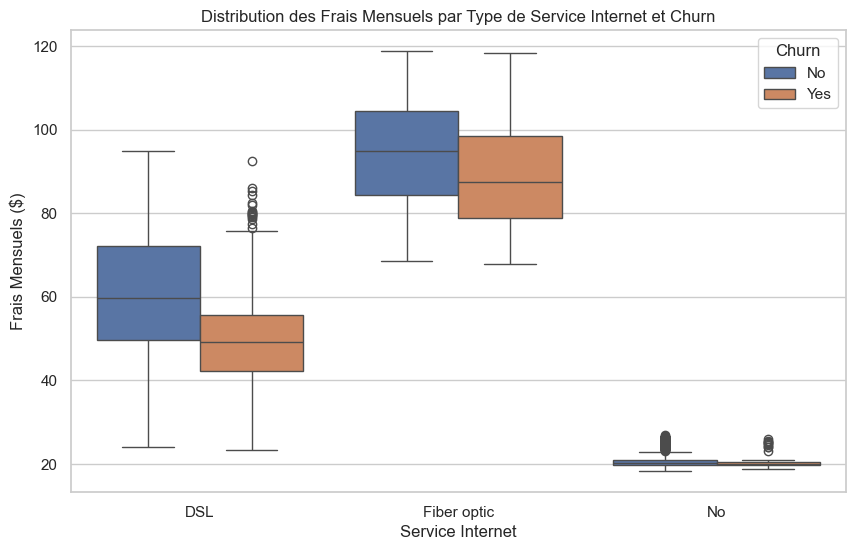

In [64]:
plt.figure(figsize=(10, 6))

sns.boxplot(data=df_main, x='InternetService', y='MonthlyCharges', hue='Churn')

plt.xlabel('Service Internet')
plt.ylabel('Frais Mensuels ($)')
plt.title('Distribution des Frais Mensuels par Type de Service Internet et Churn')

plt.show()

On a deux problèmes de churn différents. Pour la Fibre, on perd des clients "chers" (peut-être à cause du service). Pour la DSL, on perd des clients "pas chers" (peut-être parce que le forfait de base est mauvais et qu'ils partent chez un concurrent low-cost).

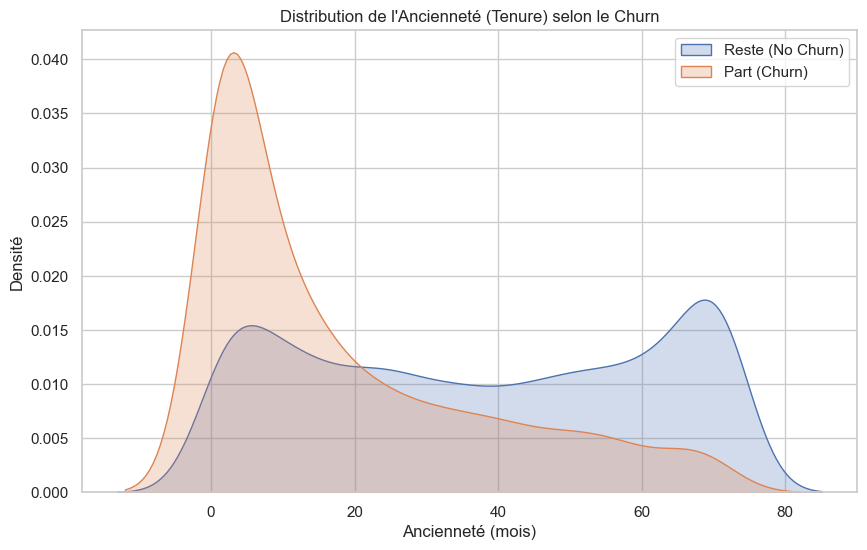

In [66]:
plt.figure(figsize=(10, 6))

sns.kdeplot(df_main[df_main['Churn'] == 'No']['tenure'], label='Reste (No Churn)', fill=True)
sns.kdeplot(df_main[df_main['Churn'] == 'Yes']['tenure'], label='Part (Churn)', fill=True)

plt.title('Distribution de l\'Ancienneté (Tenure) selon le Churn')
plt.xlabel('Ancienneté (mois)')
plt.ylabel('Densité')
plt.legend()
plt.show()

L'hypothèse H3 est validée. Le pic orange est massif et immédiat. Si un client passe le cap des 24 mois, il est probable qu'il reste à vie.
On doit concentrer nos efforts de rétention (onboarding, support proactif, offres spéciales) massivement sur les clients de 0 à 12 mois.

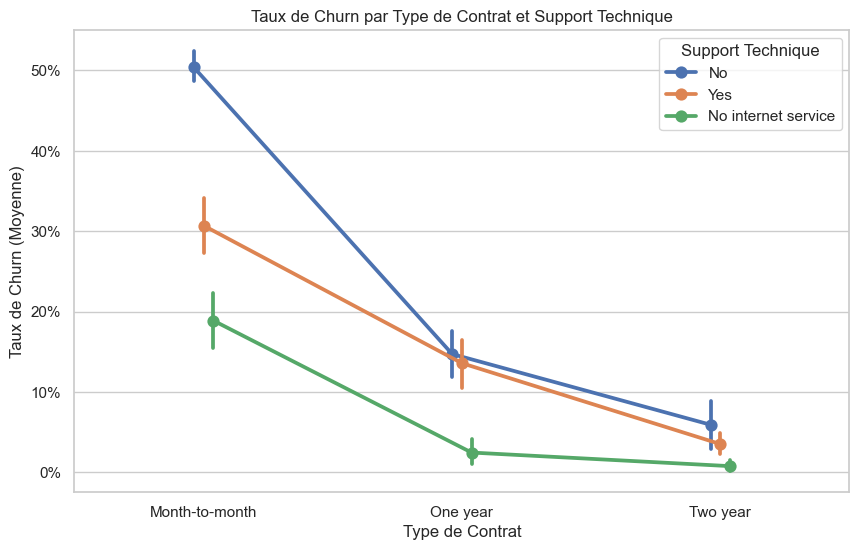

In [ ]:
plt.figure(figsize=(10, 6))

sns.pointplot(data=df_main, x='Contract', y='Churn_numeric', hue='TechSupport', dodge=True)
plt.title('Taux de Churn par Type de Contrat et Support Technique')
plt.xlabel('Type de Contrat')
plt.ylabel('Taux de Churn (Moyenne)')
plt.legend(title='Support Technique')

from matplotlib.ticker import PercentFormatter
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))

plt.show()

L'analyse montre que le simple fait de vendre (ou d'offrir ?) le TechSupport aux clients "Month-to-month" pourrait réduire leur churn de 20 points. C'est un levier d'action immédiat. Pour le long terme, on pourrait essayer de convertir les clients avec un contrat "Month-to-Month" en "Two Year".

In [69]:
df_main.to_csv('data/telco_churn_cleaned_for_bi.csv', index=False)